<a href="https://colab.research.google.com/github/DataDrivenAkanksha/Deep_learning_Covid19_xray_detection/blob/main/Covid19_Detection_Chest_X_rays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mini Project: COVID-19 Detection from Chest X-rays using CNN

Objective

A healthcare startup aims to accelerate and improve COVID-19 diagnosis using deep learning technologies. The current testing procedures are time-consuming and rely heavily on manual radiological examination, which limits scalability in pandemic situations.

As a data scientist, your task is to build a Convolutional Neural Network (CNN) model that can automatically detect COVID-19 from chest X-ray images. This solution can help hospitals:

· Reduce diagnosis time.

· Minimize burden on radiologists.

· Scale testing across regions with limited radiological expertise.

This project allows you to apply deep learning concepts, understand how CNNs process image data, and build real-world applications that can assist the medical community.

Dataset

You will use the dataset provided in the following Kaggle project: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset

The dataset contains:

· COVID-19 chest X-ray images

· Normal (no disease) chest X-ray images

· Viral Pneumonia chest X-ray images

---

Data Dictionary

Each image is labelled into one of the following classes:

· COVID-19 – Confirmed COVID infection.

· Viral Pneumonia – Non-COVID lung infection.

· Normal – No visible lung abnormality.



1. Data Loading and Exploration

    · Import necessary libraries (os, cv2, matplotlib, tensorflow, keras etc.)

    · Import Covid19 dataset from Kaggle into colab using Kaggle API.

    · Load images from different folders and label them

    · Resize images to a fixed shape (e.g 128x128 or 224x224)

    · Display a few sample images from each class

    · Print dataset size per class

---

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d pranavraikokte/covid19-image-dataset

Dataset URL: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
License(s): CC-BY-SA-4.0
 63% 100M/158M [00:00<00:00, 1.04GB/s]
100% 158M/158M [00:00<00:00, 832MB/s] 


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/covid19-image-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

##Loading dataset with one-hot encoded labels and dividing into training , validation and test data set.
##Split the data into training, validation and test sets (e.g 80-20%)

In [8]:
# Load dataset with one-hot encoded labels, as label mode is categorical and output is using softmax

ds_train = keras.utils.image_dataset_from_directory(
    directory = '/content/Covid19-dataset/train',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=42
)

# Split into training and validation
val_size = int(len(ds_train) * 0.2)
ds_train, ds_val = ds_train.skip(val_size), ds_train.take(val_size)

# Loading the test data
ds_test = keras.utils.image_dataset_from_directory(
    directory = '/content/Covid19-dataset/test',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=42
)

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


##Dispalying a few sample images from each class of training dataset

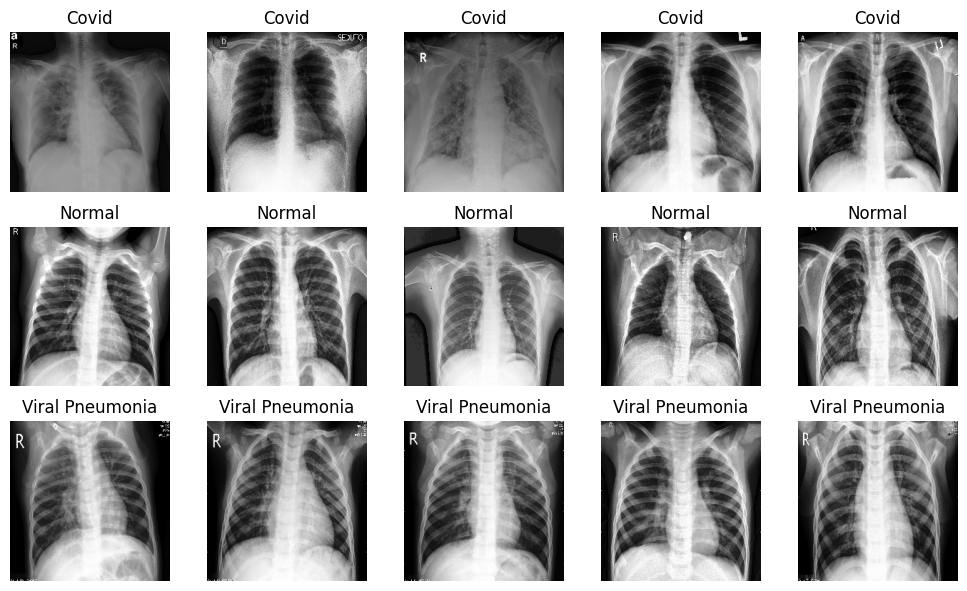

In [9]:
# Display a few sample images from each class
import matplotlib.pyplot as plt
import numpy as np

class_names=['Covid','Normal','Viral Pneumonia']
# Number of classes
num_classes = len(class_names)

# Number of samples per class
samples_per_class = 5

# Create a dictionary to store sample images per class
sample_images = {i: [] for i in range(num_classes)}

# Iterate over dataset until we have enough samples
for image_batch, label_batch in ds_train:
    for img, lbl in zip(image_batch, label_batch):
        # Find the index of the maximum value in the one-hot encoded label
        lbl = np.argmax(lbl.numpy())
        if len(sample_images[lbl]) < samples_per_class:
            sample_images[lbl].append(img.numpy())
    # Stop early if all classes have enough samples
    if all(len(sample_images[i]) >= samples_per_class for i in range(num_classes)):
        break

# Plotting
plt.figure(figsize=(samples_per_class * 2, num_classes * 2))
for label in range(num_classes):
    for i in range(samples_per_class):
        plt.subplot(num_classes, samples_per_class, label * samples_per_class + i + 1)
        plt.imshow(sample_images[label][i].astype("uint8"))
        plt.title(class_names[label])
        plt.axis("off")

plt.tight_layout()
plt.show()

## Showing the images per class

In [10]:
def get_dataset_info(dataset, class_names=None):
    total_samples = 0
    class_counts = {i: 0 for i in range(num_classes)}

    for images, labels in dataset:
        batch_size = labels.shape[0]
        total_samples += batch_size
        for label in labels:
            class_index = np.argmax(label.numpy())
            class_counts[class_index] += 1


    print(f"Total samples: {total_samples}")
    for label, count in class_counts.items():
        name = class_names[label] if class_names else f"Class {label}"
        print(f"{name}: {count} samples")


print("Training Dataset:")
get_dataset_info(ds_train, class_names)

print("\nTesting Dataset:")
get_dataset_info(ds_test, class_names)


Training Dataset:
Total samples: 219
Covid: 97 samples
Normal: 58 samples
Viral Pneumonia: 64 samples

Testing Dataset:
Total samples: 66
Covid: 26 samples
Normal: 20 samples
Viral Pneumonia: 20 samples


## Exploratory Data Analysis (EDA)

· Visualize class distribution using bar plots

· Plot sample images with their class names

· Observe patterns in data

Training Dataset:
Total samples: 219
Covid: 96 samples
Normal: 62 samples
Viral Pneumonia: 61 samples


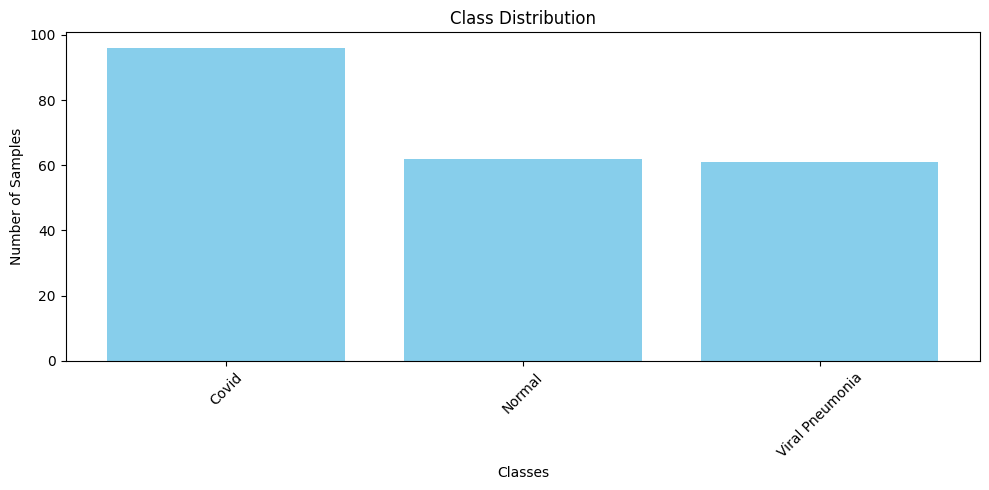


Testing Dataset:
Total samples: 66
Covid: 26 samples
Normal: 20 samples
Viral Pneumonia: 20 samples


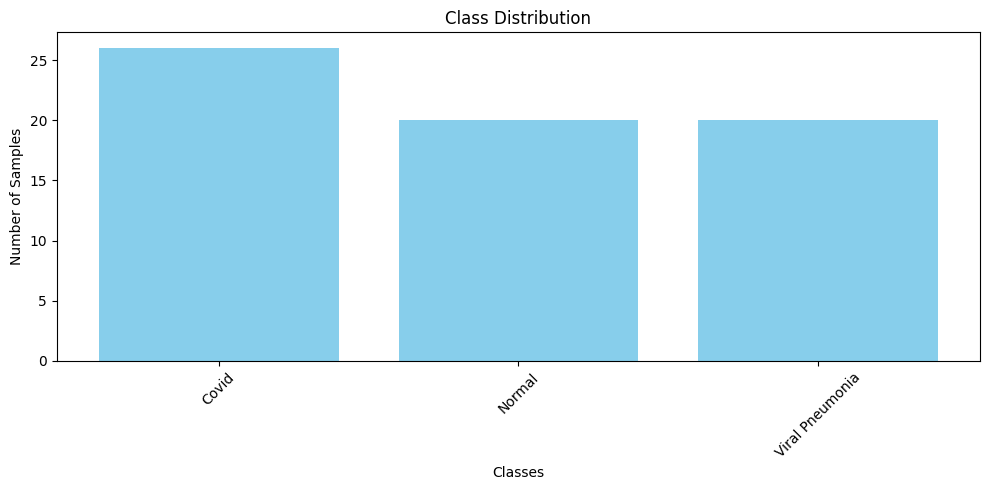

In [11]:

# visualize class distribution using bar plot

import matplotlib.pyplot as plt

def get_dataset_info(dataset, class_names=None):
    # Infer number of classes from class_names if available
    num_classes = len(class_names) if class_names else 10  # Default to 10 classes
    total_samples = 0
    class_counts = {i: 0 for i in range(num_classes)}

    # Count samples per class
    for images, labels in dataset:
        batch_size = labels.shape[0]
        total_samples += batch_size
        for label in labels:
            class_index = np.argmax(label.numpy())
            class_counts[class_index] += 1

    # Print dataset info
    print(f"Total samples: {total_samples}")
    for label, count in class_counts.items():
        name = class_names[label] if class_names else f"Class {label}"
        print(f"{name}: {count} samples")

    # Plot bar chart
    labels = [class_names[i] if class_names else f"Class {i}" for i in range(num_classes)]
    counts = [class_counts[i] for i in range(num_classes)]

    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts, color='skyblue')
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("Training Dataset:")
get_dataset_info(ds_train, class_names)

print("\nTesting Dataset:")
get_dataset_info(ds_test, class_names)

In [12]:
import matplotlib.pyplot as plt

def show_sample_images(dataset, class_names=None, num_images=9):
    plt.figure(figsize=(10, 10))
    class_names=['Covid','Normal','Viral Pneumonia']
    # Get one batch from the dataset
    for images, labels in dataset.take(1):
        for i in range(num_images):
            plt.subplot(3, 3, i + 1)
            image = images[i]
            label = labels[i].numpy()

            # If image is a tensor, convert to numpy
            if hasattr(image, 'numpy'):
                image = image.numpy()

            # If image has only 1 channel, squeeze it
            if image.shape[-1] == 1:
                image = image.squeeze(-1)

            plt.imshow(image.astype("uint8"))
            plt.axis("off")

            if class_names:
                class_index = np.argmax(label)
                plt.title(class_names[class_index])
            else:
                plt.title(f"Class {label}")

        break

    plt.tight_layout()
    plt.show()


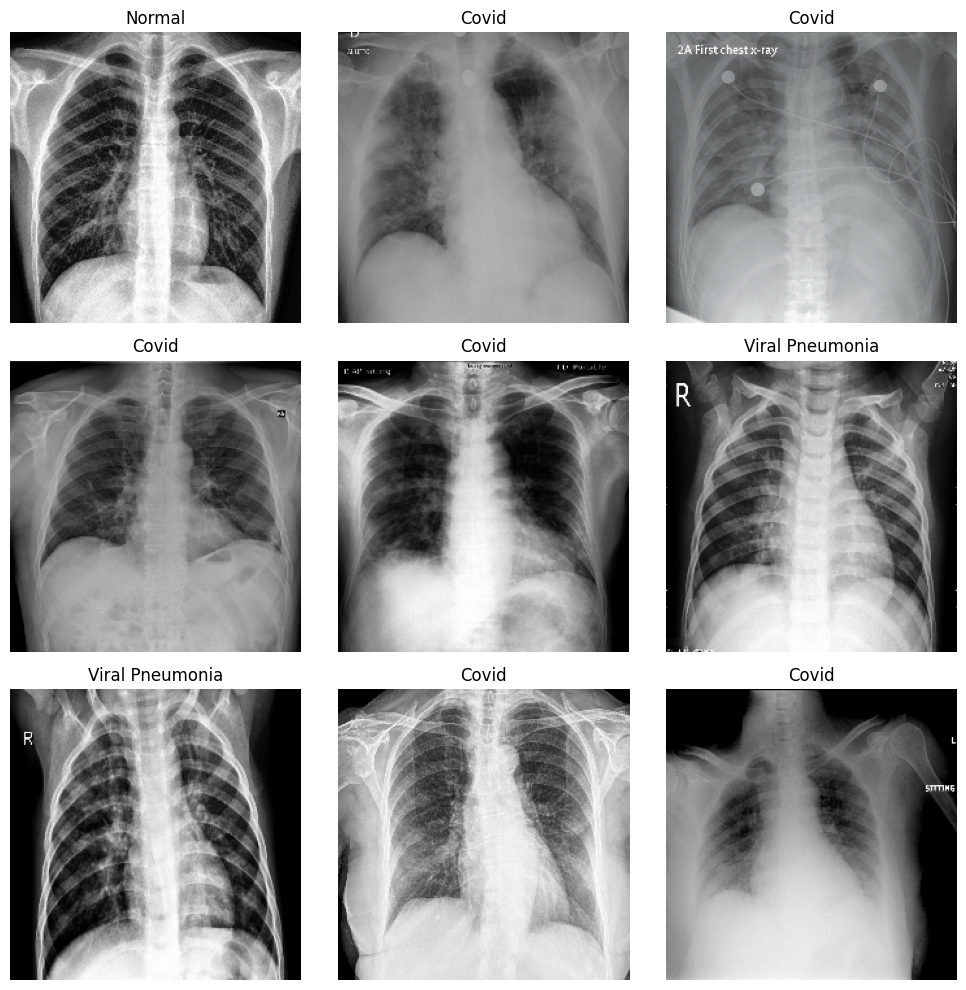

In [13]:
show_sample_images(ds_train, class_names=None, num_images=9)

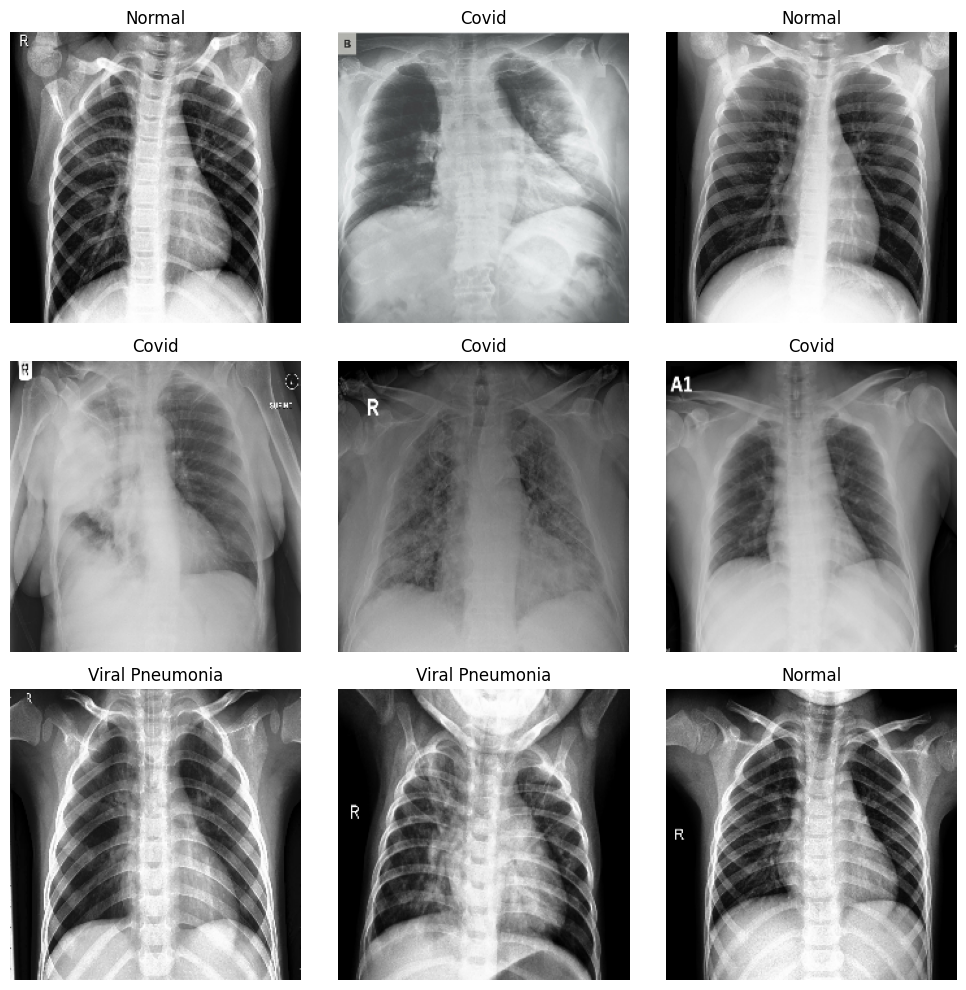

In [14]:
show_sample_images(ds_test, class_names=None, num_images=9)

##Data Preprocessing
Normalize pixel values (scale from 0–255 to 0–1)


In [15]:
#Normalize pixel values (scale from 0–255 to 0–1)
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

ds_train = ds_train.map(process)
ds_val = ds_val.map(process)
ds_test = ds_test.map(process)

4. CNN Model Building

Create and train multiple CNN architectures:

· Model 1: Basic CNN

    Conv2D -> MaxPooling -> Flatten -> Dense



In [16]:
# Basic CNN (Few layers e.g. 2-3 conv layers)

basic_model=Sequential()
basic_model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(224,224,3)))
basic_model.add(BatchNormalization())
basic_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

basic_model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
basic_model.add(BatchNormalization())
basic_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

basic_model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
basic_model.add(BatchNormalization())
basic_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

basic_model.add(Flatten())

basic_model.add(Dense(64,activation='relu'))
basic_model.add(Dropout(0.2))
basic_model.add(Dense(32,activation='relu'))
basic_model.add(Dropout(0.2))
basic_model.add(Dense(3,activation='softmax'))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
basic_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,634,179 (21.49 MB)

 Trainable params: 5,633,731 (21.49 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
basic_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

## Using Early stopping to reduce overfitting

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history1 = basic_model.fit(ds_train,epochs=50,validation_data=ds_val, callbacks=[early_stopping])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5712 - loss: 3.2335 - val_accuracy: 0.2812 - val_loss: 7.7290
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 481ms/step - accuracy: 0.7673 - loss: 2.7753 - val_accuracy: 0.6875 - val_loss: 0.8983
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 577ms/step - accuracy: 0.7606 - loss: 3.0173 - val_accuracy: 0.8438 - val_loss: 0.4705
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.8873 - loss: 1.9071 - val_accuracy: 0.8750 - val_loss: 0.2461
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 444ms/step - accuracy: 0.8902 - loss: 1.0038 - val_accuracy: 0.5625 - val_loss: 2.5056
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 603ms/step - accuracy: 0.9054 - loss: 0.9026 - val_accuracy: 0.6562 - val_loss: 2.0696
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - accuracy: 0.9023 - loss: 0.6390 - val_accuracy: 0.5000 - val_loss: 9.1135
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 403ms/step - accuracy: 0.9351 - loss: 0.2975 - val_accuracy: 0.5000 - val_loss: 

In [20]:
basic_model.evaluate(ds_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step - accuracy: 0.7655 - loss: 0.8170


[0.7594066858291626, 0.7575757503509521]

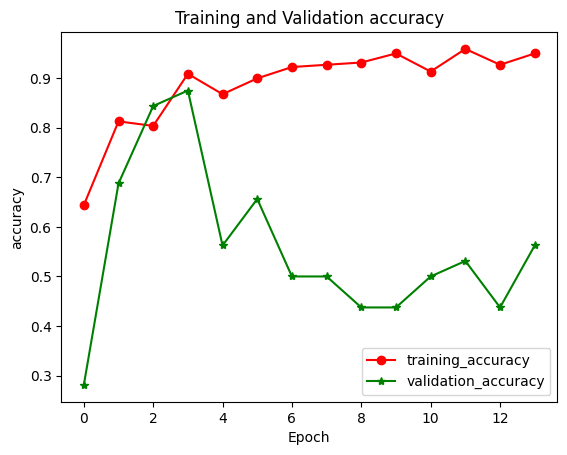

In [21]:
plt.plot(history1.history['accuracy'],label='training_accuracy',marker='o',color='red')
plt.plot(history1.history['val_accuracy'],label='validation_accuracy',marker='*',color='green')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [22]:
import numpy as np

def dataset_to_numpy(dataset):
    images = []
    labels = []

    for batch in dataset:
        batch_images, batch_labels = batch
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())

    X = np.concatenate(images)
    y = np.concatenate(labels)
    return X, y


In [23]:
X_train, y_train = dataset_to_numpy(ds_train)
X_val, y_val   = dataset_to_numpy(ds_val)
X_test, y_test   = dataset_to_numpy(ds_test)


In [24]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def evaluate_classification_model(name, model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Convert one-hot encoded labels to class indices
    if y_train.ndim > 1:
        y_train = np.argmax(y_train, axis=1)
        y_test = np.argmax(y_test, axis=1)

    # Convert prediction probabilities to class indices
    if y_pred_train.ndim > 1:
        y_pred_train = np.argmax(y_pred_train, axis=1)
        y_pred_test = np.argmax(y_pred_test, axis=1)
    acc_train = accuracy_score(y_train, y_pred_train) * 100
    acc_test = accuracy_score(y_test, y_pred_test) * 100
    overfitting_score = acc_train - acc_test
    is_overfitting = 'Y' if overfitting_score > 10 else 'N'

    return {
        'Model': name,
        'Accuracy Train (%)': acc_train,
        'Accuracy Test (%)': acc_test,
        'Precision': precision_score(y_test, y_pred_test, average='weighted'),
        'Recall': recall_score(y_test, y_pred_test, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred_test, average='weighted'),
        'Overfitting(Y/N)': is_overfitting
    }



models = [
    ('Basic_CNN', basic_model),
    # Add more models if needed
]

results = [evaluate_classification_model(name, model, X_train, y_train, X_test, y_test) for name, model in models]
results_df = pd.DataFrame(results).round(3)
print(results_df.to_string(index=False))

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
    Model  Accuracy Train (%)  Accuracy Test (%)  Precision  Recall  F1-Score Overfitting(Y/N)
Basic_CNN              88.128             75.758      0.759   0.758     0.745                Y


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


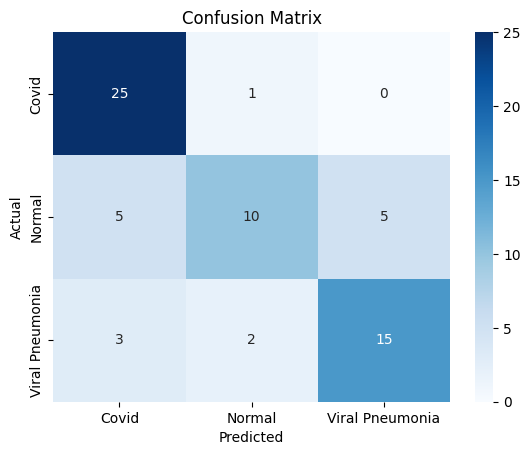

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_probs = basic_model.predict(X_test)

# Convert probabilities to class labels (indices)
y_pred_test = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded y_test to class labels if needed
if y_test.ndim > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_test)

# Plot confusion matrix with seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [26]:
from collections import Counter
print(Counter(np.argmax(y_train, axis=1)))  # For training labels
print(Counter(np.argmax(y_test, axis=1)))   # For test labels


Counter({np.int64(0): 97, np.int64(2): 61, np.int64(1): 61})
Counter({np.int64(0): 26, np.int64(2): 20, np.int64(1): 20})


In [27]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_labels, y_pred_test, target_names=class_names))

                 precision    recall  f1-score   support

          Covid       0.76      0.96      0.85        26
         Normal       0.77      0.50      0.61        20
Viral Pneumonia       0.75      0.75      0.75        20

       accuracy                           0.76        66
      macro avg       0.76      0.74      0.73        66
   weighted avg       0.76      0.76      0.74        66



The data is imbalaced, that might be the reason for predicting the covid.

## Deep CNN : Adding more convolution layers in the architectutre

In [28]:
# Deep CNN (Few layers >3 conv layers)

Deep_CNN=Sequential()
Deep_CNN.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(224,224,3)))
Deep_CNN.add(BatchNormalization())
Deep_CNN.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

Deep_CNN.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
Deep_CNN.add(BatchNormalization())
Deep_CNN.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

Deep_CNN.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
Deep_CNN.add(BatchNormalization())
Deep_CNN.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

Deep_CNN.add(Conv2D(256,kernel_size=(3,3),padding='valid',activation='relu'))
Deep_CNN.add(BatchNormalization())
Deep_CNN.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

Deep_CNN.add(Conv2D(512,kernel_size=(3,3),padding='valid',activation='relu'))
Deep_CNN.add(BatchNormalization())
Deep_CNN.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

Deep_CNN.add(Flatten())

Deep_CNN.add(Dense(64,activation='relu'))
Deep_CNN.add(Dropout(0.2))
Deep_CNN.add(Dense(32,activation='relu'))
Deep_CNN.add(Dropout(0.2))
Deep_CNN.add(Dense(3,activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
Deep_CNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,393,987 (9.13 MB)

 Trainable params: 2,392,003 (9.12 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [30]:
Deep_CNN.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history2 = basic_model.fit(ds_train,epochs=50,validation_data=ds_val, callbacks=[early_stopping])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - accuracy: 0.9268 - loss: 0.5844 - val_accuracy: 0.8125 - val_loss: 0.5033
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 525ms/step - accuracy: 0.9464 - loss: 0.2980 - val_accuracy: 0.8438 - val_loss: 0.7048
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 427ms/step - accuracy: 0.9207 - loss: 0.8847 - val_accuracy: 0.5625 - val_loss: 10.9751
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 446ms/step - accuracy: 0.9430 - loss: 0.3269 - val_accuracy: 0.4062 - val_loss: 31.1269
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 404ms/step - accuracy: 0.9242 - loss: 0.4425 - val_accuracy: 0.3125 - val_loss: 52.5615
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - accuracy: 0.9378 - loss: 1.0033 - val_accuracy: 0.3438 - val_loss: 39.1500
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 604ms/step - accuracy: 0.9425 - loss: 0.4744 - val_accuracy: 0.6250 - val_loss: 8.9662
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 425ms/step - accuracy: 0.9485 - loss: 0.6980 - val_accuracy: 0.5312 - val_l

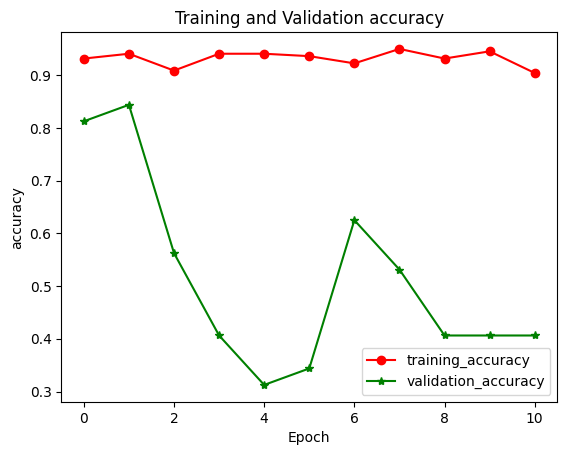

In [32]:
plt.plot(history2.history['accuracy'],label='training_accuracy',marker='o',color='red')
plt.plot(history2.history['val_accuracy'],label='validation_accuracy',marker='*',color='green')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [33]:
models = [
    ('Basic_CNN', basic_model),
     ('Deep_CNN', Deep_CNN),
    # Add more models if needed
]

results = [evaluate_classification_model(name, model, X_train, y_train, X_test, y_test) for name, model in models]
results_df = pd.DataFrame(results).round(3)
print(results_df.to_string(index=False))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step
    Model  Accuracy Train (%)  Accuracy Test (%)  Precision  Recall  F1-Score Overfitting(Y/N)
Basic_CNN              72.146             71.212      0.723   0.712     0.696                N
 Deep_CNN              27.854             30.303      0.092   0.303     0.141                N


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


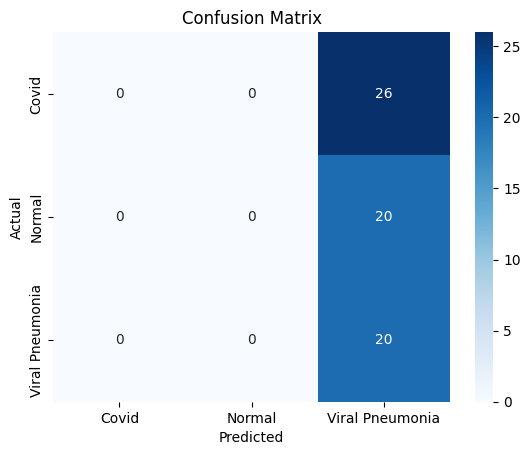

In [34]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_probs = Deep_CNN.predict(X_test)

# Convert probabilities to class labels (indices)
y_pred_test = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded y_test to class labels if needed
if y_test.ndim > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_test)

# Plot confusion matrix with seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [35]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_labels, y_pred_test, target_names=class_names))

                 precision    recall  f1-score   support

          Covid       0.00      0.00      0.00        26
         Normal       0.00      0.00      0.00        20
Viral Pneumonia       0.30      1.00      0.47        20

       accuracy                           0.30        66
      macro avg       0.10      0.33      0.16        66
   weighted avg       0.09      0.30      0.14        66



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


· Model 2: Transfer Learning

    Use pre-trained models like VGG16, ResNet50 etc

    Fine-tune last few layers on the COVID dataset



VGG16

In [36]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model_vgg16_pretrained = Sequential()
model_vgg16_pretrained.add(conv_base)
model_vgg16_pretrained.add(Flatten())
model_vgg16_pretrained.add(Dense(64, activation='relu'))
model_vgg16_pretrained.add(Dropout(0.2))
model_vgg16_pretrained.add(Dense(32,activation='relu'))
model_vgg16_pretrained.add(Dropout(0.2))
model_vgg16_pretrained.add(Dense(3,activation='softmax'))

In [38]:
conv_base.trainable = False
model_vgg16_pretrained.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,322,563 (62.27 MB)

 Trainable params: 1,607,875 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
model_vgg16_pretrained.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [40]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history3=model_vgg16_pretrained.fit(ds_train,epochs=50,validation_data=ds_val, callbacks=[early_stopping])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.4017 - loss: 1.2269 - val_accuracy: 0.9375 - val_loss: 0.5990
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 677ms/step - accuracy: 0.7412 - loss: 0.6892 - val_accuracy: 0.9062 - val_loss: 0.3514
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 467ms/step - accuracy: 0.7428 - loss: 0.5690 - val_accuracy: 0.9062 - val_loss: 0.2996
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 442ms/step - accuracy: 0.8826 - loss: 0.3886 - val_accuracy: 0.9062 - val_loss: 0.3109
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 421ms/step - accuracy: 0.8669 - loss: 0.3442 - val_accuracy: 0.9375 - val_loss: 0.1426
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 0.8834 - loss: 0.3419 - val_accuracy: 0.9688 - val_loss: 0.1938
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 532ms/step - accuracy: 0.9422 - loss: 0.2144 - val_accuracy: 1.0000 - val_loss: 0.1260
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step - accuracy: 0.9229 - loss: 0.2044 - val_accuracy: 1.0000 - val_loss: 

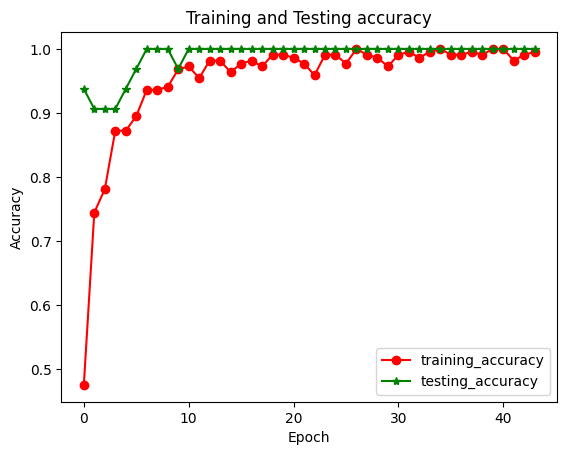

In [41]:

plt.plot(history3.history['accuracy'],label='training_accuracy',marker='o',color='red')
plt.plot(history3.history['val_accuracy'],label='testing_accuracy',marker='*',color='green')
plt.title('Training and Testing accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


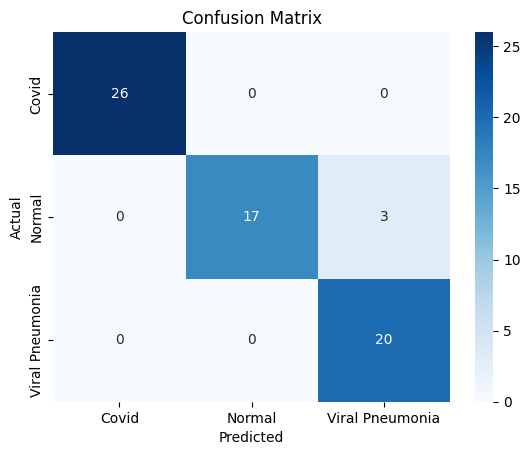

In [42]:
# Predict class probabilities
y_pred_probs = model_vgg16_pretrained.predict(X_test)

# Convert probabilities to class labels (indices)
y_pred_test = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded y_test to class labels if needed
if y_test.ndim > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_test)

# Plot confusion matrix with seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [43]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_labels, y_pred_test, target_names=class_names))


                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       1.00      0.85      0.92        20
Viral Pneumonia       0.87      1.00      0.93        20

       accuracy                           0.95        66
      macro avg       0.96      0.95      0.95        66
   weighted avg       0.96      0.95      0.95        66



In [44]:
models = [
    ('Basic_CNN', basic_model),
    ('Deep_CNN', Deep_CNN),
    ('VGG16', model_vgg16_pretrained),
    # Add more models if needed
]

results = [evaluate_classification_model(name, model, X_train, y_train, X_test, y_test) for name, model in models]
results_df = pd.DataFrame(results).round(3)
print(results_df.to_string(index=False))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step 
    Model  Accuracy Train (%)  Accuracy Test (%)  Precision  Recall  F1-Score Overfitting(Y/N)
Basic_CNN              72.146             71.212      0.723   0.712     0.696                N
 Deep_CNN              27.854             30.303      0.092   0.303     0.141                N
    VGG16             100.000             95.455      0.960   0.955     0.954                N


#Resnet50

In [45]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

conv_base = ResNet50(weights='imagenet',
                     include_top=False,
                     input_shape=(224, 224, 3))

conv_base.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [46]:
model_resnet50_pretrained = Sequential()
model_resnet50_pretrained.add(conv_base)
model_resnet50_pretrained.add(Flatten())
model_resnet50_pretrained.add(Dense(64, activation='relu'))
model_resnet50_pretrained.add(Dropout(0.2))
model_resnet50_pretrained.add(Dense(32,activation='relu'))
model_resnet50_pretrained.add(Dropout(0.2))
model_resnet50_pretrained.add(Dense(3,activation='softmax'))

In [47]:
conv_base.trainable = False
model_resnet50_pretrained.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,012,483 (114.49 MB)

 Trainable params: 6,424,771 (24.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [48]:
model_resnet50_pretrained.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [49]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history4=model_resnet50_pretrained.fit(ds_train,epochs=50,validation_data=ds_val, callbacks=[early_stopping])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.3656 - loss: 4.1351 - val_accuracy: 0.4062 - val_loss: 1.6615
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 601ms/step - accuracy: 0.3418 - loss: 2.2693 - val_accuracy: 0.4062 - val_loss: 1.0304
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 480ms/step - accuracy: 0.2852 - loss: 1.1819 - val_accuracy: 0.1562 - val_loss: 1.0870
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 421ms/step - accuracy: 0.2936 - loss: 1.0823 - val_accuracy: 0.3750 - val_loss: 1.0758
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 652ms/step - accuracy: 0.3305 - loss: 1.0593 - val_accuracy: 0.5312 - val_loss: 1.0277
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 395ms/step - accuracy: 0.3582 - loss: 1.0609 - val_accuracy: 0.4375 - val_loss: 1.0241
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 462ms/step - accuracy: 0.3794 - loss: 1.0329 - val_accuracy: 0.5625 - val_loss: 0.9848
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 556ms/step - accuracy: 0.3788 - loss: 1.0117 - val_accuracy: 0.4062 - val_loss: 

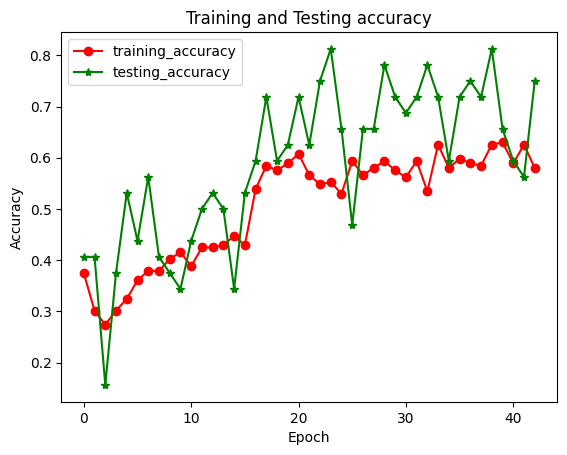

In [50]:
plt.plot(history4.history['accuracy'],label='training_accuracy',marker='o',color='red')
plt.plot(history4.history['val_accuracy'],label='testing_accuracy',marker='*',color='green')
plt.title('Training and Testing accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


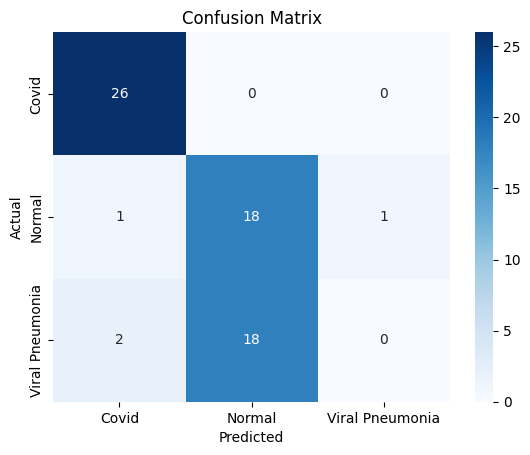

In [51]:
# Predict class probabilities
y_pred_probs = model_resnet50_pretrained.predict(X_test)

# Convert probabilities to class labels (indices)
y_pred_test = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded y_test to class labels if needed
if y_test.ndim > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_test)

# Plot confusion matrix with seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [52]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_labels, y_pred_test, target_names=class_names))

                 precision    recall  f1-score   support

          Covid       0.90      1.00      0.95        26
         Normal       0.50      0.90      0.64        20
Viral Pneumonia       0.00      0.00      0.00        20

       accuracy                           0.67        66
      macro avg       0.47      0.63      0.53        66
   weighted avg       0.50      0.67      0.57        66



In [53]:
models = [
    ('Basic_CNN', basic_model),
    ('Deep_CNN', Deep_CNN),
    ('VGG16', model_vgg16_pretrained),
    ('ResNet50', model_resnet50_pretrained),
    # Add more models if needed
]

results = [evaluate_classification_model(name, model, X_train, y_train, X_test, y_test) for name, model in models]
results_df = pd.DataFrame(results).round(3)
print(results_df.to_string(index=False))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
    Model  Accuracy Train (%)  Accuracy Test (%)  Precision  Recall  F1-Score Overfitting(Y/N)
Basic_CNN              72.146             71.212      0.723   0.712     0.696                N
 Deep_CNN              27.854             30.303      0.092   0.303     0.141                N
    VGG16             100.000             95.455      0.960   0.955     0.954                N
 ResNet50              69.406             66.667      0.505   0.667     0.567                N


· Model 3: Transfer Learning + Data Augmentation

    Do the data Augmentation using ImageDataGenerator.

    The use the pretrained models to get the prediction.

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# Define the augmenter
train_datagen = ImageDataGenerator(

    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,

)

# No augmentation for validation/test
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

# Create generators from NumPy arrays
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=32,
    shuffle=False
)

test_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=32,
    shuffle=False
)

Vgg16 + data Augmentation

In [55]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model_vgg16_pretrained_data_aug = Sequential()
model_vgg16_pretrained_data_aug.add(conv_base)
model_vgg16_pretrained_data_aug.add(Flatten())
model_vgg16_pretrained_data_aug.add(Dense(64, activation='relu'))
model_vgg16_pretrained_data_aug.add(Dropout(0.2))
model_vgg16_pretrained_data_aug.add(Dense(32,activation='relu'))
model_vgg16_pretrained_data_aug.add(Dropout(0.2))
model_vgg16_pretrained_data_aug.add(Dense(3,activation='softmax'))

In [57]:
conv_base.trainable = False
model_vgg16_pretrained_data_aug.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,322,563 (62.27 MB)

 Trainable params: 1,607,875 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [58]:
model_vgg16_pretrained_data_aug.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [59]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history5=model_vgg16_pretrained_data_aug.fit(train_generator,epochs=50,validation_data=val_generator, callbacks=[early_stopping])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 963ms/step - accuracy: 0.4585 - loss: 1.3210 - val_accuracy: 0.7500 - val_loss: 0.3672
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 0.5605 - loss: 0.9704 - val_accuracy: 0.7500 - val_loss: 0.4244
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step - accuracy: 0.7757 - loss: 0.4824 - val_accuracy: 0.9062 - val_loss: 0.1933
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 471ms/step - accuracy: 0.8627 - loss: 0.3940 - val_accuracy: 0.9375 - val_loss: 0.2522
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 404ms/step - accuracy: 0.8278 - loss: 0.3948 - val_accuracy: 0.9375 - val_loss: 0.1705
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 0.8572 - loss: 0.3413 - val_accuracy: 0.9688 - val_loss: 0.1281
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - accuracy: 0.9091 - loss: 0.2303 - val_accuracy: 0.9688 - val_loss: 0.1333
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 520ms/step - accuracy: 0.9793 - loss: 0.1553 - val_accuracy: 0.9688 - val_loss:

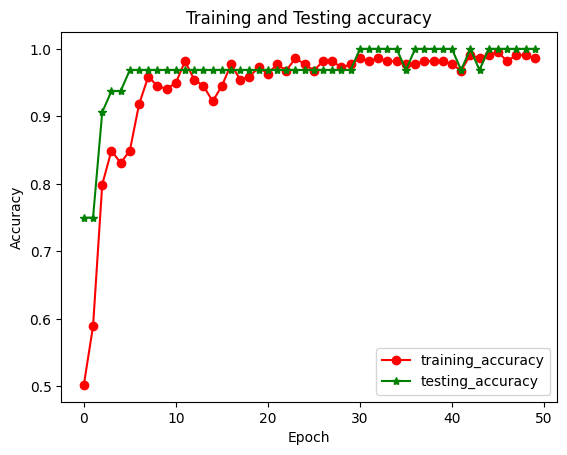

In [60]:
plt.plot(history5.history['accuracy'],label='training_accuracy',marker='o',color='red')
plt.plot(history5.history['val_accuracy'],label='testing_accuracy',marker='*',color='green')
plt.title('Training and Testing accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step


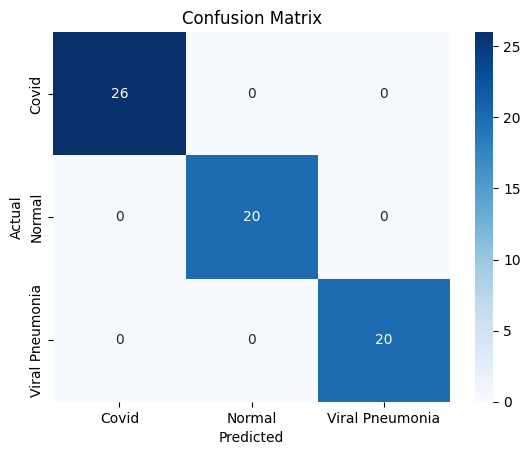

In [61]:
# Predict class probabilities
y_pred_probs = model_vgg16_pretrained_data_aug.predict(X_test)

# Convert probabilities to class labels (indices)
y_pred_test = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded y_test to class labels if needed
if y_test.ndim > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_test)

# Plot confusion matrix with seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [62]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_labels, y_pred_test, target_names=class_names))

                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       1.00      1.00      1.00        20
Viral Pneumonia       1.00      1.00      1.00        20

       accuracy                           1.00        66
      macro avg       1.00      1.00      1.00        66
   weighted avg       1.00      1.00      1.00        66



In [63]:
models = [
    ('Basic_CNN', basic_model),
    ('Deep_CNN', Deep_CNN),
    ('VGG16', model_vgg16_pretrained),
    ('ResNet50', model_resnet50_pretrained),
    ('VGG16_data_aug', model_vgg16_pretrained_data_aug),
    # Add more models if needed
]

results = [evaluate_classification_model(name, model, X_train, y_train, X_test, y_test) for name, model in models]
results_df = pd.DataFrame(results).round(3)
print(results_df.to_string(index=False))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step 
         Model  Accuracy Train (%)  Accuracy Test (%)  Precision  Recall  F1-Score Overfitting(Y/N)
     Basic_CNN              72.146             71.212      0.723   0.712     0.696                N
      Deep_CNN              27.854             30.303      0.092   0.303     0.141                N
         VGG16             100.000             95.455      0.960   0.955     0.954                N
      ResNet50              69.406             66.667      0.505   0.667     0.567                N
VGG16_data_aug             100.000            100.000      1.000   1.000     1.000                N


Resnet50 + data augmentation

In [64]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
conv_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [65]:
model_resnet50_pretrained_data_aug = Sequential()
model_resnet50_pretrained_data_aug.add(conv_base)
model_resnet50_pretrained_data_aug.add(Flatten())
model_resnet50_pretrained_data_aug.add(Dense(64, activation='relu'))
model_resnet50_pretrained_data_aug.add(Dropout(0.2))
model_resnet50_pretrained_data_aug.add(Dense(32,activation='relu'))
model_resnet50_pretrained_data_aug.add(Dropout(0.2))
model_resnet50_pretrained_data_aug.add(Dense(3,activation='softmax'))

In [66]:
conv_base.trainable = False
model_resnet50_pretrained_data_aug.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,012,483 (114.49 MB)

 Trainable params: 6,424,771 (24.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [67]:
model_resnet50_pretrained_data_aug.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history6=model_resnet50_pretrained_data_aug.fit(train_generator,epochs=50,validation_data=val_generator, callbacks=[early_stopping])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3985 - loss: 1.9717 - val_accuracy: 0.4062 - val_loss: 1.4304
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - accuracy: 0.3710 - loss: 2.1942 - val_accuracy: 0.4688 - val_loss: 0.9398
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.3615 - loss: 1.3865 - val_accuracy: 0.4062 - val_loss: 1.1024
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - accuracy: 0.4167 - loss: 1.1280 - val_accuracy: 0.6562 - val_loss: 0.9329
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - accuracy: 0.4993 - loss: 1.1347 - val_accuracy: 0.4062 - val_loss: 1.0907
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - accuracy: 0.4638 - loss: 1.0921 - val_accuracy: 0.4062 - val_loss: 1.0932
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - accuracy: 0.4375 - loss: 1.0914 - val_accuracy: 0.4062 - val_loss: 1.0922
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 483ms/step - accuracy: 0.4162 - loss: 1.0928 - val_accuracy: 0.4062 - val_loss: 1

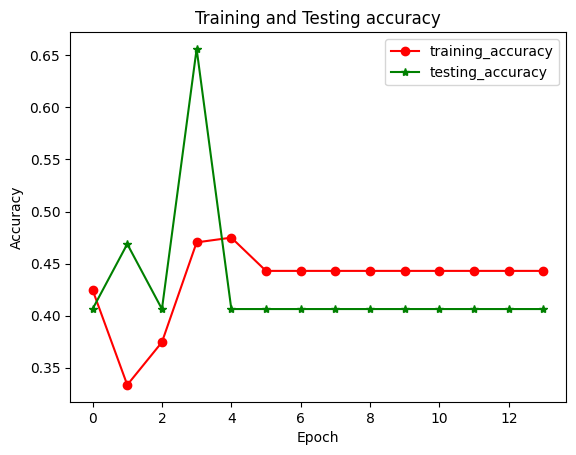

In [69]:
plt.plot(history6.history['accuracy'],label='training_accuracy',marker='o',color='red')
plt.plot(history6.history['val_accuracy'],label='testing_accuracy',marker='*',color='green')
plt.title('Training and Testing accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


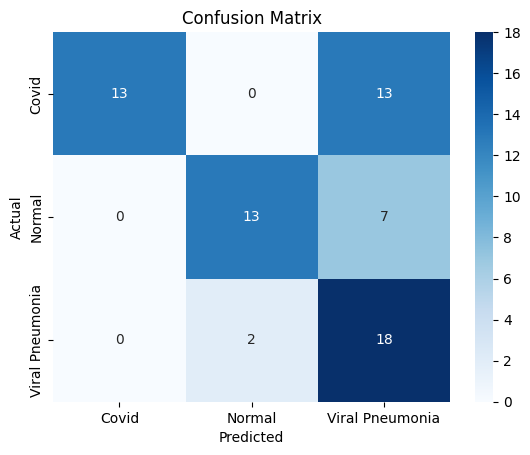

In [70]:
# Predict class probabilities
y_pred_probs = model_resnet50_pretrained_data_aug.predict(X_test)

# Convert probabilities to class labels (indices)
y_pred_test = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded y_test to class labels if needed
if y_test.ndim > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_test)

# Plot confusion matrix with seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [71]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_labels, y_pred_test, target_names=class_names))

                 precision    recall  f1-score   support

          Covid       1.00      0.50      0.67        26
         Normal       0.87      0.65      0.74        20
Viral Pneumonia       0.47      0.90      0.62        20

       accuracy                           0.67        66
      macro avg       0.78      0.68      0.68        66
   weighted avg       0.80      0.67      0.68        66



In [72]:
models = [
    ('Basic_CNN', basic_model),
    ('Deep_CNN', Deep_CNN),
    ('VGG16', model_vgg16_pretrained),
    ('ResNet50', model_resnet50_pretrained),
    ('VGG16_data_aug', model_vgg16_pretrained_data_aug),
    ('ResNet50_data_aug', model_resnet50_pretrained_data_aug),
    # Add more models if needed
]

results = [evaluate_classification_model(name, model, X_train, y_train, X_test, y_test) for name, model in models]
results_df = pd.DataFrame(results).round(3)
print(results_df.to_string(index=False))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
            Model  Accuracy Train (%)  Accuracy Test (%)  Precision  Recall  F1-Score Overfitting(Y/N)
        Basic_CNN              72.146             71.212      0.723   0.712     0.696                N
         Deep_CNN              27.854             30.303      0.092   0.303     0.141                N
            VGG16             100.000             95.455      0.960   0.955     0.954                N
         ResNet50              69.406             66.667      0.505   0.667     0.567                N
   VGG16_data_aug             100.000            100.000      1.000   1.000     1.000                N
ResNet50_data_aug              50.228             66.667      0.800   0.6

In [74]:
# Saving the model
model_vgg16_pretrained_data_aug.save('model_vgg16_pretrained_data_aug.h5')

In [76]:
model_vgg16_pretrained_data_aug.save('model_vgg16_pretrained_data_aug.keras')

Final summary

| Model              | Accuracy Train (%) | Accuracy Test (%) | Precision | Recall | F1-Score | Overfitting(Y/N) |
|--------------------|--------------------|--------------------|-----------|--------|----------|------------------|
| Basic_CNN          | 44.292             | 42.424             | 0.498     | 0.424  | 0.341    | N                |
| Deep_CNN           | 35.160             | 39.394             | 0.223     | 0.394  | 0.275    | N                |
| VGG16              | 100.000            | 95.455             | 0.960     | 0.955  | 0.954    | N                |
| ResNet50           | 57.078             | 57.576             | 0.410     | 0.576  | 0.478    | N                |
| VGG16_data_aug     | 99.543             | 93.939             | 0.949     | 0.939  | 0.939    | N                |
| ResNet50_data_aug  | 68.950             | 65.152             | 0.522     | 0.652  | 0.558    | N                |


In [77]:
model_vgg16_pretrained.save('model_vgg16_pretrained.h5')